In [2]:
import tensorflow as tf
tf.version.VERSION

'2.8.0'

In [3]:
# set Keras backend to Tensorflow
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [4]:
# import
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import pickle
import numpy as np

In [5]:
# make saving directory
saveDir = "./cifar10/semiTest30/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [6]:
# get Cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x train shape:', x_train.shape)
print(x_train.shape[0], 'training images')
print(x_test.shape[0], 'test images')

x train shape: (50000, 32, 32, 3)
50000 training images
10000 test images


In [7]:
from keras.utils import np_utils
# prerequisite
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [8]:
initNum = 10000
x_train1 = x_train[:initNum]
y_train1 = y_train[:initNum]
remainXTrain = x_train[initNum:]
remainYTrain = y_train[initNum:]

In [9]:
print("initial training X: {0}\n\
initial training Y: {1}\n\
remaining training X: {2}\n\
remaining training Y: {3}\n\
test X: {4}\n\
test Y: {5}".format(
    x_train1.shape,y_train1.shape,remainXTrain.shape,remainYTrain.shape,x_test.shape,y_test.shape))

initial training X: (10000, 32, 32, 3)
initial training Y: (10000, 10)
remaining training X: (40000, 32, 32, 3)
remaining training Y: (40000, 10)
test X: (10000, 32, 32, 3)
test Y: (10000, 10)


In [10]:
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [11]:
from tensorflow.keras.optimizers import Adam

# optimization and compile
def compileModel(model, lr=0.001, decay=1e-6):
    opt = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [12]:
# define layers
def getModel(loadModel=False, modelFilePath="", lr=0.001, decay=1e-6):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model = compileModel(model)
    
    # load model weights if specified
    if loadModel == True:
        model.load_weights(modelFilePath)
    
    return model

In [13]:
# get the newest model file
def getNewestModel(dirname=saveDir):
    import os
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return getModel()
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        return getModel(True, newestModel[0])

In [14]:
# get the CNN model
model = getModel()

In [15]:
# train the model
def trainModel(model, xTrain, yTrain, xTest, yTest, batch_size=50, epochs=100, patience=1):
    es_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
    chkpt = os.path.join(saveDir, 'Cifar10_.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5')
    cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    # train
    model.fit(xTrain, yTrain,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(xTest, yTest),
              callbacks=[es_cb, cp_cb],
              shuffle=True)
    return model

In [16]:
# run training on the initial dataset

model = trainModel(model, x_train1, y_train1, x_test, y_test, patience=2)


Epoch 1: val_loss improved from inf to 1.55834, saving model to ./cifar10/semiTest30\Cifar10_.01-1.93-1.56.hdf5

Epoch 2: val_loss improved from 1.55834 to 1.35019, saving model to ./cifar10/semiTest30\Cifar10_.02-1.51-1.35.hdf5

Epoch 3: val_loss improved from 1.35019 to 1.27080, saving model to ./cifar10/semiTest30\Cifar10_.03-1.35-1.27.hdf5

Epoch 4: val_loss improved from 1.27080 to 1.25845, saving model to ./cifar10/semiTest30\Cifar10_.04-1.22-1.26.hdf5

Epoch 5: val_loss improved from 1.25845 to 1.10887, saving model to ./cifar10/semiTest30\Cifar10_.05-1.11-1.11.hdf5

Epoch 6: val_loss did not improve from 1.10887

Epoch 7: val_loss improved from 1.10887 to 1.06409, saving model to ./cifar10/semiTest30\Cifar10_.07-0.92-1.06.hdf5

Epoch 8: val_loss improved from 1.06409 to 1.01481, saving model to ./cifar10/semiTest30\Cifar10_.08-0.83-1.01.hdf5

Epoch 9: val_loss improved from 1.01481 to 0.99449, saving model to ./cifar10/semiTest30\Cifar10_.09-0.74-0.99.hdf5

Epoch 10: val_loss 

In [17]:
# use the pre-trained model, with 65% accuracy on test data
# model = getNewestModel()
model.load_weights("./cifar10/semiTest30/Cifar10_.09-0.74-0.99.hdf5")

In [18]:
# define evaluation method
def evaluate(model, xTest, yTest, display=False):
    # only shows loss and accuracy
    if display == False:
        ev = model.evaluate(xTest, yTest, verbose=0)
        return ev
    # shows confusion matrix, classification report and accuracy score
    else:
        import pandas as pd
        import seaborn as sn
        import matplotlib.pyplot as plt
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report, accuracy_score

        def toNum(y):
            yNum = []
            for x in y:
                yNum.append(x.argmax())
            return np.array(yNum)

        # visualize confusion matrix on heat map
        def print_cmx(y_true, y_pred):
            labels = sorted(list(set(y_true)))
            cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

            df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

            plt.figure(figsize = (10,7))
            sn.heatmap(df_cmx, annot=True)
            plt.show()

        # reshape testing target to fit to scikit-learn metric form
        y_testPred = model.predict(xTest)
        y_testP = toNum(y_testPred)
        y_true = toNum(yTest)

        # get confusion matrix, classification report and accuracy score
        print_cmx(y_true, y_testP)
        print(classification_report(y_true, y_testP))
        print("Accuracy: {0}".format(accuracy_score(y_true, y_testP)))

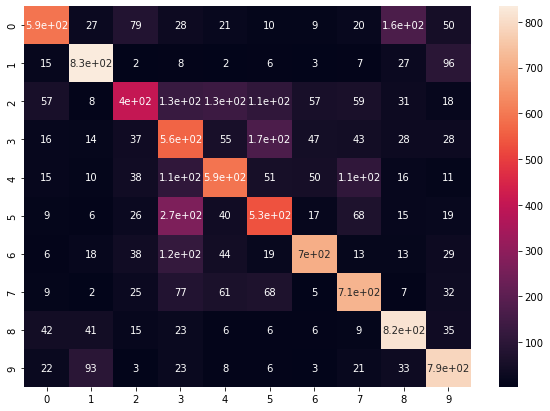

              precision    recall  f1-score   support

           0       0.76      0.59      0.66      1000
           1       0.79      0.83      0.81      1000
           2       0.60      0.40      0.48      1000
           3       0.42      0.56      0.48      1000
           4       0.62      0.59      0.60      1000
           5       0.55      0.53      0.54      1000
           6       0.78      0.70      0.74      1000
           7       0.67      0.71      0.69      1000
           8       0.71      0.82      0.76      1000
           9       0.71      0.79      0.75      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000

Accuracy: 0.6538


In [19]:
# evaluate the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [20]:
# record the loss and accuracy
evalHistory = []
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])


[0.994488000869751, 0.6538000106811523]


In [21]:
# get a list of high probability inference
def getHighProb(proba, bound):
    ls = []
    for i in range(len(proba)):
        for p in range(len(proba[i])):
            if proba[i,p] > bound:
                ls.append([i,p])
    return ls

In [22]:
# concatenate initial training data with high probability inference, removing them from remaining data

from keras import utils as np_utils


def concatHighProbData(proba, remainX, remainY, xTrain, yTrain, bound=0.99):
    hp = getHighProb(proba, bound)
    print("number of data with probability higher than {0}: {1}".format(bound,len(hp)))
    
    nhp = np.array(hp)
    xAdd = remainX[nhp[:,0]]
    yAdd = np.array([nhp[:,1]]).T
    yAdd = keras.utils.np_utils.to_categorical(yAdd, num_classes)
    yActual = remainY[nhp[:,0]]
    print("x shape to be added: {0}\ny shape to be added: {1}".format(xAdd.shape, yAdd.shape))
    
    NewXTrain = np.vstack((xTrain, xAdd))
    NewYTrain = np.vstack((yTrain, yAdd))
    print("new training data:\n\tx: {0}\n\ty: {1}".format(NewXTrain.shape, NewYTrain.shape))
    
    remainX2 = np.delete(remainX, nhp[:,0], axis=0)
    remainY2 = np.delete(remainY, nhp[:,0], axis=0)
    print("remaining data:\n\tx: {0}\n\ty: {1}".format(remainX2.shape, remainY2.shape))
    
    yEval = [[yActual[i],yAdd[i]] for i in range(len(yAdd))]
    
    return remainX2, remainY2, NewXTrain, NewYTrain, yEval

In [23]:
def getError(yEval):
    errLabel = [0]*10
    for i in range(len(yEval)):
        if False in (yEval[i][0] == yEval[i][1]):
            errLabel[np.argmax(yEval[i][0]-yEval[i][1])] += 1
    return errLabel

In [24]:
# get new training data
# proba = model.predict_proba(remainXTrain, verbose=0)
proba=model.predict(remainXTrain,verbose=0)
remainXTrain, remainYTrain, x_train2, y_train2, yEval= concatHighProbData(proba, 
                                                                          remainXTrain, 
                                                                          remainYTrain, 
                                                                          x_train1, 
                                                                          y_train1, 
                                                                          0.9999)
errPred = getError(yEval)

number of data with probability higher than 0.9999: 295
x shape to be added: (295, 32, 32, 3)
y shape to be added: (295, 10)
new training data:
	x: (10295, 32, 32, 3)
	y: (10295, 10)
remaining data:
	x: (39705, 32, 32, 3)
	y: (39705, 10)


In [25]:
# retrain the model
model = trainModel(model, x_train2, y_train2, x_test, y_test)


Epoch 1: val_loss improved from inf to 1.02021, saving model to ./cifar10/semiTest30\Cifar10_.01-0.63-1.02.hdf5

Epoch 2: val_loss improved from 1.02021 to 1.00151, saving model to ./cifar10/semiTest30\Cifar10_.02-0.56-1.00.hdf5

Epoch 3: val_loss did not improve from 1.00151
Epoch 3: early stopping


In [26]:
# load the newest checkpoint model to get the best accuracy one
model = getNewestModel()

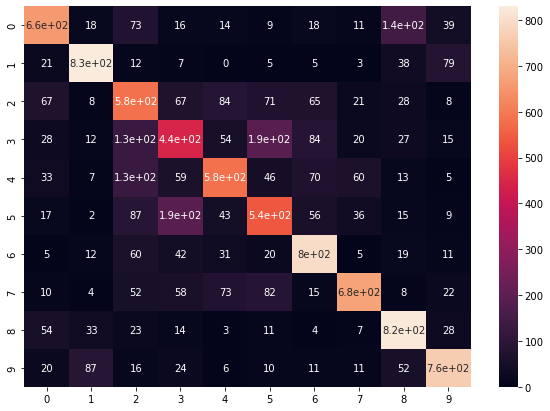

              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1000
           1       0.82      0.83      0.82      1000
           2       0.50      0.58      0.54      1000
           3       0.48      0.45      0.46      1000
           4       0.65      0.58      0.62      1000
           5       0.55      0.54      0.55      1000
           6       0.71      0.80      0.75      1000
           7       0.80      0.68      0.73      1000
           8       0.70      0.82      0.76      1000
           9       0.78      0.76      0.77      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000

Accuracy: 0.6692


In [27]:
# evaluate with the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [28]:
# record the loss and accuracy
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])

[1.0015082359313965, 0.6692000031471252]


In [29]:
for i in range(30):
    #proba = model.predict_proba(remainXTrain, verbose=0)
    proba=model.predict(remainXTrain,verbose=0)
    remainXTrain, remainYTrain, x_train2, y_train2, yEval = concatHighProbData(proba, 
                                                                               remainXTrain, 
                                                                               remainYTrain, 
                                                                               x_train2, 
                                                                               y_train2, 
                                                                               0.9999)
    errPred2 = getError(yEval)
    errPred = [errPred2[i]+errPred[i] for i in range(len(errPred))]
    model = trainModel(model, x_train2, y_train2, x_test, y_test)
    model = getNewestModel()
    evalHistory.append(evaluate(model, x_test, y_test, display=False))
    print("\nAfter Iter: {0}\n\tLoss and Acc: {1}\n".format(i,evalHistory[-1]))

number of data with probability higher than 0.9999: 678
x shape to be added: (678, 32, 32, 3)
y shape to be added: (678, 10)
new training data:
	x: (10973, 32, 32, 3)
	y: (10973, 10)
remaining data:
	x: (39027, 32, 32, 3)
	y: (39027, 10)

Epoch 1: val_loss improved from inf to 1.10985, saving model to ./cifar10/semiTest30\Cifar10_.01-0.49-1.11.hdf5

Epoch 2: val_loss improved from 1.10985 to 1.06871, saving model to ./cifar10/semiTest30\Cifar10_.02-0.42-1.07.hdf5

Epoch 3: val_loss did not improve from 1.06871
Epoch 3: early stopping

After Iter: 0
	Loss and Acc: [1.0687118768692017, 0.6654000282287598]

number of data with probability higher than 0.9999: 1094
x shape to be added: (1094, 32, 32, 3)
y shape to be added: (1094, 10)
new training data:
	x: (12067, 32, 32, 3)
	y: (12067, 10)
remaining data:
	x: (37933, 32, 32, 3)
	y: (37933, 10)

Epoch 1: val_loss improved from inf to 1.13812, saving model to ./cifar10/semiTest30\Cifar10_.01-0.37-1.14.hdf5

Epoch 2: val_loss did not improve

RuntimeError: Can't decrement id ref count (unable to extend file properly)